### Natural Language Processing - Assignment 1

__Group Members:__

## <font color=red> Classification of comments (Toxic and Non_Toxic)
#### <font color=Green> 1. Aanal Kamleshkumar Patel - C0910376</font>
#### <font color=Green>2. Bimal Shresta - C0919385</font>
#### <font color=Green>3. Danilo Diaz - C0889539</font>
#### <font color=Green>4. Ernie Sumoso - C0881591</font>
#### <font color=Green>5. Jayachandhran Saravanan - C0910392</font>
 

### Dataset and Onedrive links

The following are the one-drive links of,
1.	Dataset - https://mylambton-my.sharepoint.com/:t:/g/personal/c0910392_mylambton_ca/EcggPBlaeKNCmzN9G1CraKQBuxcQEDxJqiHqF3VO5w7haQ?e=9ZUGp6
2.	Test data - https://mylambton-my.sharepoint.com/:x:/g/personal/c0910392_mylambton_ca/EZEuzDzRneFGqgt-Te3tp9IBTHkm-4shgqytOVtkJFzLlQ?e=KuqEGx
3.	Whole working folder - https://mylambton-my.sharepoint.com/:f:/g/personal/c0910392_mylambton_ca/Eh4w8X4LpBJGnMbTNYXXJjoB5X7W3P5Olyuek5g8Fx8NDw?e=resDYJ
4.	Git hub - https://github.com/svjai/NLP_AML_2304_2


### Index
- __0. Data Source Explanation__
- __1. Dataset Collection__
- __2. Exploratory Data Analysis__
- __3. Data Cleaning & Text Processing__
- __4. Word Clouds__
- __5. Word Vectorization methods__
- __6. Model Building__
- __7. Evaluating Model Results__

### 0. Data Source explanation

For this project we have selected __textual data from video comments__ as our data source.

This data is annotated into 2 possible categories: __violent threat (1)__ or __not violent threat (0)__.

The origin of the data is found within the paper called: __"THREAT: A Large Annotated Corpus for Detection of Violent Threats"__

which was published in reputable organizations like __IEEE__ and __Semantic Scholar__.

On the abstract, the authors state that the dataset consist on around __30'000 sentences from 10'000 different Youtube video comments__ (real data). Each sentence was labelled manually.

The purpose of this public dataset is to enable the development of tools (such as the one we are working on this project) to __analyze online threats and/or hateful speech__.

To be more specific, we are provided with the following txt file: __VideoCommentsThreatCorpus.txt__, from which we will extract our texts and labels.

We have downloaded the dataset and saved it within a personal __Google Drive repository__ to avoid future issues, and have the data available for us at any moment.

Original sources (IEEE and Semantic Scholar):
- https://ieeexplore.ieee.org/document/8877435
- https://www.semanticscholar.org/paper/THREAT%3A-A-Large-Annotated-Corpus-for-Detection-of-Hammer-Riegler/32b11247f4232d1262633b3cd48b6de3a2360632

### 1. Dataset Collection
Let's start by acquiring our dataset from an external source.

The columns of our dataset are as follows:
- __text__: raw textual data
- __label__: 0 --> the text does not contain a violent threat, 1 --> the text contains a violent threat

First, to gather our data, let's import some required libraries.

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import os # used for file manipulation
import sys # used for file manipulation
import re # used for regular expression
from urllib import request

Let's create a __Helper class__ that will allow us to __extract (download) the data__ from its original source (Google Drive).

This class will also allow us to __read the file and return a DataFrame__ from Pandas library.

In [2]:
# Helper class to download and read the dataset
class Helper:
    def __init__(self, path, id_path):
        self.path = path
        self.id_path = id_path

    def download_dataset(self):
        # Download the dataset from the original source Google Drive
        url = f"https://drive.google.com/uc?export=download&id={self.id_path}"
        request.urlretrieve(url, self.path)

    def read_dataset(self, path):
        # Read the dataset, and return the DataFrame from Pandas
        def read_lines(lines):
            is_header = True
            for line in lines:
                if is_header:
                    is_header = False
                    continue

                if not line or line.isspace():
                    is_header = True
                    continue
                # let's create a generator so we don't store the whole content in memory
                label, comment = line.split(maxsplit=1)
                yield comment, int(label)

        with open(path, encoding="utf-8") as file:
            data = read_lines(file)
            df = pd.DataFrame.from_records(data, columns=["text", "label"])

        return df

Let's __instantiate our Helper class__ and __donwload the data from its original source__ and obtain the data from the file as a __DataFrame__.

In [3]:
# instantiate our custom Helper class
helper = Helper(
    path='dataset',
    id_path='13XlJ4uhxxGprn6mnXwXNvV9PxSNyZCsY'
)
# download our dataset from its original source
helper.download_dataset()
# read the dataset as a DataFrame from Pandas
df = helper.read_dataset('dataset')
df.head()

,text,label
0,It's because Europeans do not want to change t...,0
1,The Muslims there do not want to assimilate pr...,0
2,But it's ok....because Europe will soon rebel ...,1
3,I forsee a big civil war in Europe in the futu...,0
4,"ISLAM – A Simple, Humanitarian and Attractive ...",0


Now we have the dataset ready for an exploratory data analysis (EDA) inside the __df__ variable.

### 2. Exploratory Data Analysis

Let's start our EDA. For this task we have implemented a class called __ExploratoryDataAnalysis__ that takes the following __parameters for initialization__:
- DataFrame from Pandas library
- String defining target column name

... and calculates some basic analysis over the data.

Some of the implemented methods are capable of:

- Displaying and plotting the __Value counts of our target column__
- Displaying and plotting the number of rows with __missing values__ within our dataframe
- Displaying and plotting the number of __duplicated rows__ within our dataframe

The purpose of creating a class and methods was to avoid repetitive code and to enable ourselves to re-use the code with different datasets.

In [4]:
import matplotlib.pyplot as plt # library for 2D and 3D plots
plt.style.use('ggplot')
import random # randomize functions

In [5]:
# let's implement a class that will perform an EDA through the use of methods
class ExploratoryDataAnalysis:
    
    def __init__(self, df, target_column_name, lines=30):
        self.df = df
        self.target_column_name = target_column_name
        self.lines = lines
        self.colors = ['#DBFFD7', '#ffd7db', '#d7dbff', '#fbd7ff', '#e2d8d4', '#ffc7bb']
        self.color_pairs = []
        self.set_color_pairs()
    
    def set_color_pairs(self):
        # let's set the color pairs for our plots
        for i in range(3):
            color_1 = random.choice(self.colors)
            colors_copy = self.colors[:]
            colors_copy.remove(color_1)
            color_2 = random.choice(colors_copy)
            self.color_pairs.append((color_1, color_2))
        
    def print_line(self, custom_lines=-1):
        if custom_lines != -1:
            print("-" * custom_lines)
            return
        print("-" * self.lines)
    
    def display_shape(self):
        # check for the shape (number of rows and columns) of the dataset
        print("SHAPE")
        print("# Rows:\t", df.shape[0])
        print("# Columns:", df.shape[1])
    
    def display_target_value_counts(self, percentage=False):
        # check for the distribution of target values, take percentage flag into account
        print("TARGET VALUE COUNTS", percentage * "PERCENTAGE (%)")
        print(df[self.target_column_name].value_counts(normalize = percentage) * (100 if percentage else 1))
        print("Total:", "100.00 %" if percentage else df[self.target_column_name].count())
        
    def display_missing_values(self, percentage=False):
        # check for missing values, take percentage flag into account
        print("MISSING VALUES", percentage * "PERCENTAGE (%)")
        print(df.isnull().mean() * 100 if percentage else df.isnull().sum())
        print("Total:", "100.00 %" if percentage else df.isnull().sum().sum())
        
    def display_duplicates(self, percentage=False):
        # check for duplicate values, take percentage flag into account
        print("DUPLICATED ROWS", percentage * "PERCENTAGE (%)")
        print("Total:", "{:.2f} %".format(df.duplicated().mean() * 100) if percentage else df.duplicated().sum())
        
    def display_basic_analysis(self):
        # make use of the previous defined methods to display a basic EDA
        self.print_line()
        self.display_shape()
        self.print_line()
        self.display_target_value_counts()
        self.print_line()
        self.display_target_value_counts(percentage=True)
        self.print_line()
        self.display_missing_values()
        self.print_line()
        self.display_missing_values(percentage=True)
        self.print_line()
        self.display_duplicates()
        self.print_line()
        self.display_duplicates(percentage=True)
        self.print_line()
    
    def plot_target_value_counts(self, ax):
        # to plot we need to set our x and y values first
        x = df[self.target_column_name].unique()
        y = df[self.target_column_name].value_counts()
        # plot the bar in the subplot canvas, using a random generated color
        ax.bar(x, y, color= self.color_pairs[0])
        
        # let's add annotation to our bar graph
        for x_, y_ in zip(x, y): # zip creates the following tuples: (1st x value, 1st y value), (2nd, 2nd) ...
            label = "{:,} ({:.2f} %)".format(y_, y_ * 100/y.sum()).replace(',', "'")
            # annotate at the x and y position, add some offset to center the annotations
            ax.annotate(label, (x_ - 0.2, y_ + 150))
            
        # let's add some titles to the subplot and axis
        ax.title.set_text("Target Value Counts")
        ax.set_xlabel("Unique Values")
        ax.set_ylabel("Value Counts")
        
    def plot_missing_values(self, ax):
        # to plot we need to set our x and y values first
        x = df.columns.to_list()
        y = df.isnull().sum()
        ax.bar(x, y, color = self.color_pairs[1], width = 0.4)
        
        # if there's no missing values we can write it down explicitely using text method
        if y.sum().sum() == 0:
            ax.text(0.5, 0.5, 'No Missing Values', transform=ax.transAxes,
                    fontsize=40, color='gray', alpha=0.5, ha='center', va='center', rotation=25)
        
        # let's add some titles to the subplot and axis
        ax.title.set_text("Missing Values")
        ax.set_xlabel("Column Name")
        ax.set_ylabel("# Rows with Missing Values")
        
    def plot_duplicates(self, ax):
        # to plot we need to set our x and y values first
        x = ['# Non-duplicated Rows', '# Duplicated Rows']
        y = [df.shape[0] - df.duplicated().sum(), df.duplicated().sum()]
        ax.bar(x, y, color = self.color_pairs[2], width = 0.4)
        
        # let's add annotation to our bar graph
        for x_, y_ in enumerate(y): # zip creates the following tuples: (1st x value, 1st y value), (2nd, 2nd) ...
            label = "{:,} ({:.2f} %)".format(y_, y_ * 100/sum(y)).replace(',', "'")
            # annotate at the x and y position, add some offset to center the annotations
            ax.annotate(label, (x_ - 0.2, y_ + 150))
            
        # let's add some titles to the subplot and axis
        ax.title.set_text("Duplicated Rows")
        ax.set_ylabel("# Rows")
        
    def plot_pie_target_value_counts(self, ax):
        # let's set the unique values of our target column, and their value counts
        labels = df[self.target_column_name].unique()
        value_counts = df[self.target_column_name].value_counts()
        
        # let's set the percentage of each value count, explode and color values
        x = [val * 100/value_counts.sum() for val in value_counts]
        explode = [0.1 for i in range(len(x))]
        colors = self.color_pairs[0]
        
        # finally, let's plot the pie
        ax.pie(x, explode, autopct="%.2f", labels=labels, colors=colors)
        
    def plot_pie_missing_values(self, ax):
        # let's set the unique values of our target column, and their value counts
        labels = ['Non-missing', 'Missing']
        value_counts = [df[df.notnull().any(axis=1)].shape[0], # number of rows with non-missing values
                        df[df.isnull().any(axis=1)].shape[0]]  # number of rows with any missing value
        
        # let's set the percentage of each value count, explode and color values
        x = [val * 100/df.shape[0] for val in value_counts]
        explode = [0.1 for i in range(len(x))]
        colors = self.color_pairs[1]
        
        # finally, let's plot the pie
        ax.pie(x, explode, autopct="%.2f", labels=labels, colors=colors)
        
    def plot_pie_duplicates(self, ax):
        # let's set the unique values of our target column, and its value counts per unique value
        labels = ['Non-duplicated', 'Duplicated']
        value_counts = [df.shape[0] - df.duplicated().sum(), df.duplicated().sum()]
        
        # let's set the percentage of each value count, explode and color values
        x = [val * 100/df.shape[0] for val in value_counts]
        explode = [0.1 for i in range(len(x))]
        colors = self.color_pairs[2]
        
        # finally, let's plot the pie
        ax.pie(x, explode, autopct="%.2f", labels=labels, colors=colors)
        
    def plot_basic_analysis(self):
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (20,10)) # rows, columns
        self.plot_target_value_counts(ax1)
        self.plot_missing_values(ax2)
        self.plot_duplicates(ax3)
        self.plot_pie_target_value_counts(ax4)
        self.plot_pie_missing_values(ax5)
        self.plot_pie_duplicates(ax6)

Now that our class is implemented we can easily perform an exploratory data analysis over our dataset.

Let's instantiate the class and call some implemented methods.

In [6]:
eda = ExploratoryDataAnalysis(df, "label") # instantiate our EDA class using "label" column as target
eda.display_basic_analysis() # print the EDA in text format

------------------------------
SHAPE
# Rows:	 28643
# Columns: 2
------------------------------
TARGET VALUE COUNTS 
0    27256
1     1387
Name: label, dtype: int64
Total: 28643
------------------------------
TARGET VALUE COUNTS PERCENTAGE (%)
0    95.15763
1     4.84237
Name: label, dtype: float64
Total: 100.00 %
------------------------------
MISSING VALUES 
text     0
label    0
dtype: int64
Total: 0
------------------------------
MISSING VALUES PERCENTAGE (%)
text     0.0
label    0.0
dtype: float64
Total: 100.00 %
------------------------------
DUPLICATED ROWS 
Total: 352
------------------------------
DUPLICATED ROWS PERCENTAGE (%)
Total: 1.23 %
------------------------------


Given the data, we have approximately __30'000 rows__ as expected. From these rows:
- Near __5% correspond to violent threat comments__. Which indicates that our __data is imbalanced__.
- There are __no missing values__, meaning all rows contain a comment (textual data) and its label.
- The __duplicated rows__ represents only near __1.5%__ of the entire dataset.

Now that we have the numbers, let's use the implemented methods to visualize our analysis.

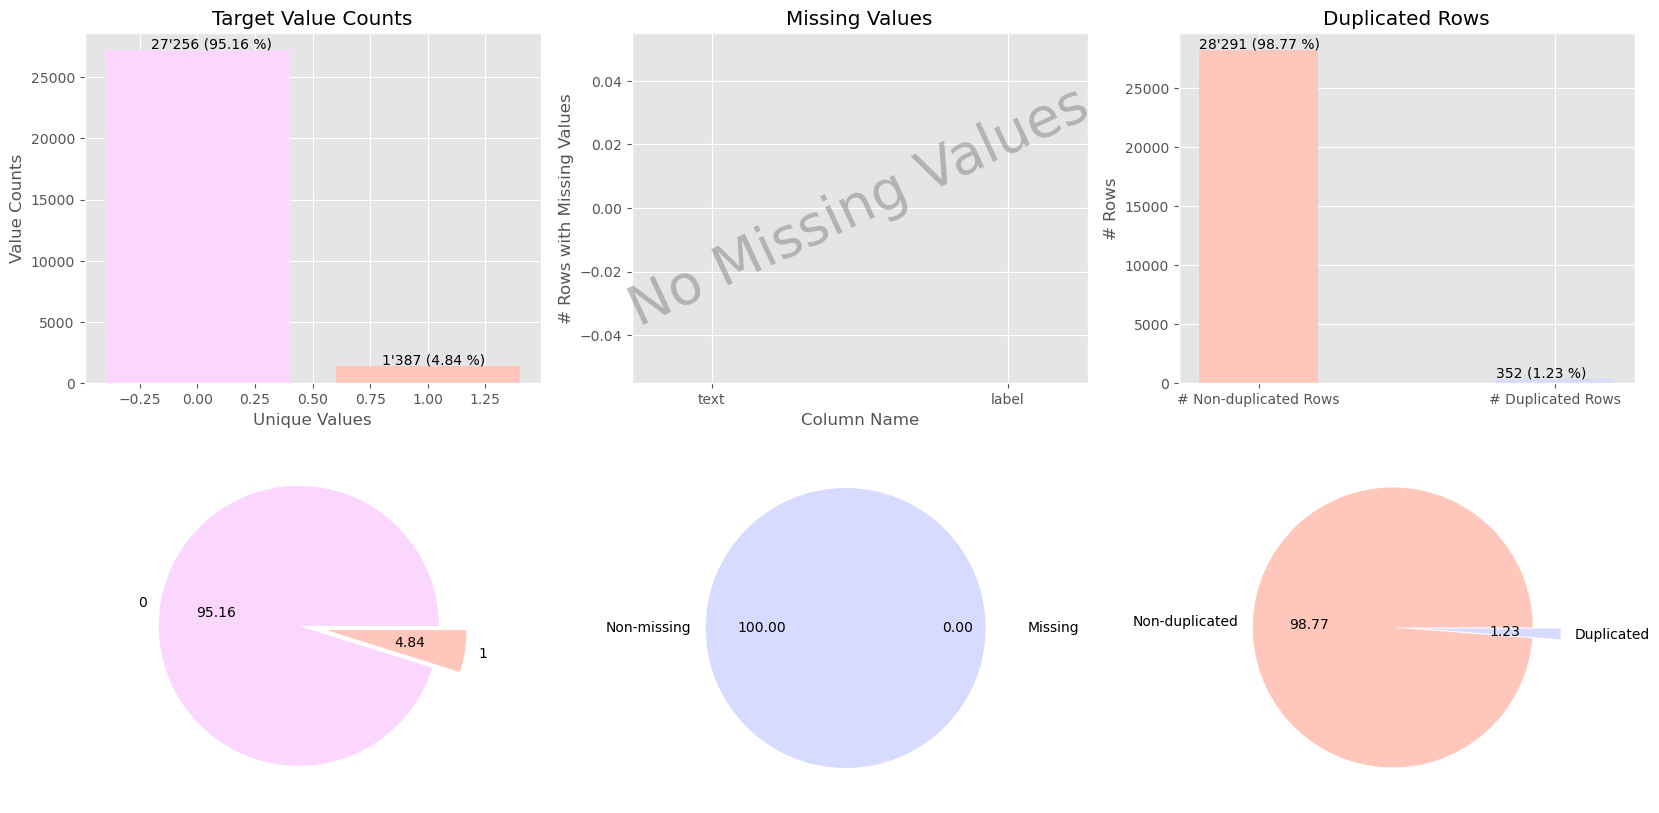

In [7]:
eda.plot_basic_analysis()

Using __bar plots and pie charts__ we are able to quickly understand the __balance of our labels__, and the amount of our duplicated rows.

Now, let's dive a little into the __duplicated rows and see their content and labels__.

In [8]:
df_duplicated = df[df.duplicated()] # DataFrame containing only duplicated rows
filter_0 = df_duplicated['label'] == 0
filter_1 = df_duplicated['label'] == 1

print(df_duplicated[filter_0].shape[0]) # number of duplicated non-violent comments
print(df_duplicated[filter_1].shape[0]) # number of duplicated non-violent comments

324
28


In [9]:
df_duplicated[filter_0].tail()

,text,label
28238,Denne kommentaren har fått for mange negative ...,0
28239,Denne kommentaren har fått for mange negative ...,0
28240,Denne kommentaren har fått for mange negative ...,0
28312,May jesus help us !\n,0
28354,Denne kommentaren har fått for mange negative ...,0


In [10]:
df_duplicated[filter_1].tail()

,text,label
25233,go kill yourself﻿\n,1
26360,Death to islam!\n,1
27408,Death to islam!\n,1
28082,HAHAHAHA CRY AND DIE\n,1
28157,BURN THEM ALL !\n,1


We have 324 duplicated rows of non-violent comments and 28 duplicated rows of violent comments.

Let's calculate the percentage on our entire dataset.

In [11]:
df_filter_0 = df['label'] == 0
df_filter_1 = df['label'] == 1

print(df_duplicated[filter_0].shape[0] * 100 / df[df_filter_0].shape[0]) # % of duplicated rows within non violent comments
print(df_duplicated[filter_1].shape[0] * 100 / df[df_filter_1].shape[0]) # % of duplicated rows within violent comments

1.1887290871734664
2.0187454938716654


### 3. Data Cleaning & Text Processing

Now that we have performed an EDA on our dataset, we have an idea of the steps that we need to follow to clean our data.

Let's start by dealing with the duplicated rows.

As our __duplicated rows consist on only 2% or less__ of the data __for each label__,

we decided to __drop__ this redundant rows so that they don't affect our model training.

In [12]:
print("Number of rows before dropping duplicates:", df.shape[0])
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
print("Number of rows after dropping duplicates:", df.shape[0])

Number of rows before dropping duplicates: 28643
Number of rows after dropping duplicates: 28291


Let's start with the text processing by adding some informative columns to our dataset.

The following information will be added for each row (comment) on our dataset:
- number of words
- number of characters
- number of special characters
- number of digits
- number of upper and lower case characters
- number of stopwords
- number of unique words

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the number of words in each comment
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Count the number of characters in each comment
df['char_count'] = df['text'].apply(lambda x: len(x))

# Count the number of special characters in each comment
df['special_char_count'] = df['text'].apply(lambda x: len([c for c in x if c in ('!','@','#','$','%','^','&','*','(',')','_','+','{','}','|',':','"','<','>','?','`','~',';',',','.','/','\\','[',']')]))

# Count the number of numerics in each comment
df['numerics_count'] = df['text'].apply(lambda x: len([c for c in x if c.isdigit()]))

# Count the number of uppercase words in each comment
df['upper_count'] = df['text'].apply(lambda x: len([c for c in x if c.isupper()]))

# Count the number of lowercase words in each comment
df['lower_count'] = df['text'].apply(lambda x: len([c for c in x if c.islower()]))

# Count the number of words in each comment
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Count the number of stopwords in each comment
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['stopwords_count'] = df['text'].apply(lambda x: len([c for c in x.split() if c in stop]))

# Count the number of unique words in each comment
df['unique_words_count'] = df['text'].apply(lambda x: len(set(x.split())))
df.tail()



,index,text,label,word_count,char_count,special_char_count,numerics_count,upper_count,lower_count,stopwords_count,unique_words_count
28286,28638,yeah we are all monsters..I'm gonna kill u rig...,1,10,56,5,0,1,39,3,10
28287,28639,stupid brainwashed idiot..\n,0,3,27,2,0,0,22,0,3
28288,28640,have you EVER been to Serbia or kosovo...fucki...,0,13,79,8,0,9,48,7,13
28289,28641,"probably u mean to this monsters, fucker /watc...",0,8,62,3,2,4,43,2,8
28290,28642,the fucking funniest thing is that fucking ame...,0,13,87,3,0,0,71,4,11


Now that we have created multiple numeric columns. It will come handy to see some statistics over the new created columns.

The describe method from Pandas DataFrame will display the following measures:
- counts
- mean
- standard deviation
- min and max values
- quartiles (25th, median, and 75th quantile)

Let's display these measures for both violent and non-violent comments.

In [14]:
df[df['label']==0].describe() # describe method only on non-violent comments

,index,label,word_count,char_count,special_char_count,numerics_count,upper_count,lower_count,stopwords_count,unique_words_count
count,26932.000000,26932.0,26932.000000,26932.000000,26932.000000,26932.000000,26932.000000,26932.000000,26932.000000,26932.000000
mean,14257.617258,0.0,14.028888,79.051537,2.238638,0.339373,4.614473,57.367889,5.588705,12.953216
std,8228.680561,0.0,11.132556,63.259047,2.468285,1.520522,15.381334,49.607612,5.435356,9.156106
min,0.000000,0.0,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7089.750000,0.0,7.000000,37.000000,1.000000,0.000000,1.000000,25.000000,2.000000,7.000000
50%,14315.500000,0.0,11.000000,62.000000,1.000000,0.000000,1.000000,44.000000,4.000000,11.000000
75%,21358.250000,0.0,18.000000,99.000000,3.000000,0.000000,3.000000,74.000000,8.000000,17.000000
max,28642.000000,0.0,108.000000,507.000000,67.000000,88.000000,396.000000,412.000000,67.000000,83.000000


In [15]:
df[df['label']==1].describe() # describe method only on non-violent comments

,index,label,word_count,char_count,special_char_count,numerics_count,upper_count,lower_count,stopwords_count,unique_words_count
count,1359.000000,1359.0,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,15547.682855,1.0,15.116262,82.760854,2.364238,0.199411,10.647535,54.115526,5.540839,13.707873
std,9008.263592,0.0,13.073364,71.426901,3.665978,0.848181,30.098001,54.345787,6.077402,10.443305
min,2.000000,1.0,2.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,8632.000000,1.0,7.000000,37.000000,1.000000,0.000000,1.000000,19.000000,1.000000,7.000000
50%,14406.000000,1.0,11.000000,62.000000,1.000000,0.000000,1.000000,41.000000,4.000000,11.000000
75%,24832.500000,1.0,19.000000,106.000000,3.000000,0.000000,4.000000,72.000000,8.000000,17.000000
max,28638.000000,1.0,92.000000,500.000000,55.000000,9.000000,405.000000,383.000000,52.000000,75.000000


Some insights from these numbers:
- In general, violent comments are somewhat longer than non-violent comments. However, non-violent comments hold most maximum values for all columns.
- The sentence count for over 75% of our data (including violent and non-violent comments) present only 1 sentence.

Let's plot the __distribution of the word count and stopwords__ using __histograms__.

This will enhance our understanding of the words and stopwords distribution within the comments.

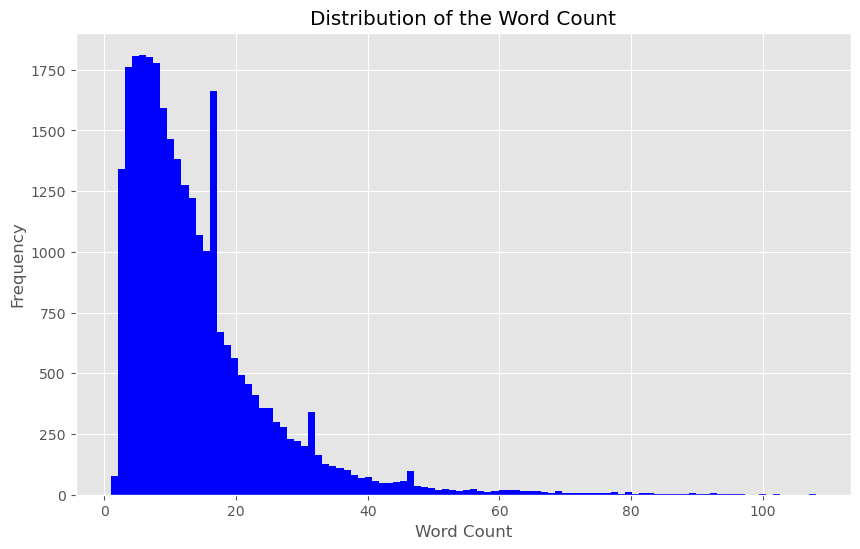

In [16]:
# Plot the distribution of the word count

plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=100, color='blue')
plt.title('Distribution of the Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

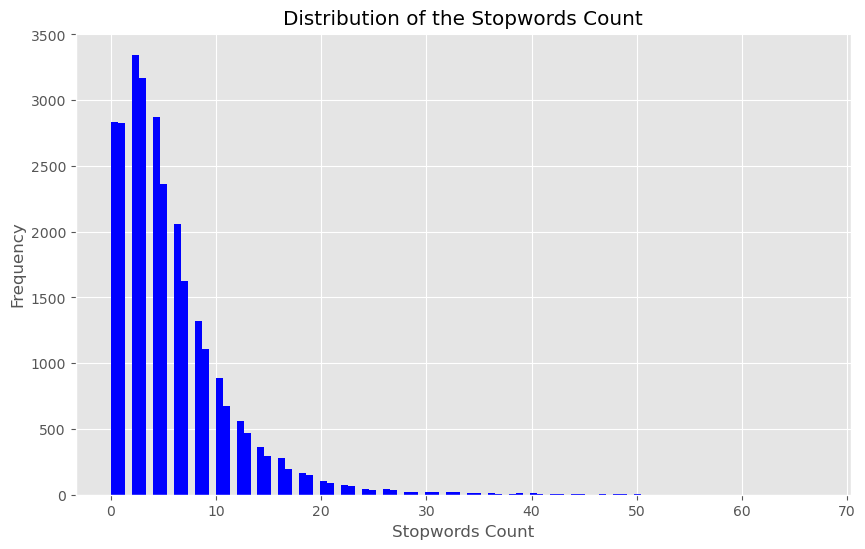

In [17]:
# Plot the distribution of the stopword count

plt.figure(figsize=(10, 6))
plt.hist(df['stopwords_count'], bins=101, color='blue')
plt.title('Distribution of the Stopwords Count')
plt.xlabel('Stopwords Count')
plt.ylabel('Frequency')
plt.show()

Both histograms are right skewed (positive skewness).

This indicates that __most comments have between 1 and 40 words__ in total, and between __0 and 20 stopwords__.

We also notice the presence of multiple outliers, which represent __comments with over 60 words, and over 30 stopwrords.__

To confirm our observations, let's __calculate the skewness and kurtosis__ on both columns.

In [18]:
# Skewness and Kurtosis of word_count
print("Skewness: %f" % df['word_count'].skew())
print("Kurtosis: %f" % df['word_count'].kurt())

Skewness: 2.474932
Kurtosis: 9.424836


In [19]:
# Skewness and Kurtosis of stopwords_count
print("Skewness: %f" % df['stopwords_count'].skew())
print("Kurtosis: %f" % df['stopwords_count'].kurt())

Skewness: 2.324923
Kurtosis: 9.248397


The calculations confirm our observations since a positive skewness means the distribution is right-skewed,

while the kurtosis measures the tailedness of our distribution, and we have a high kurtosis value.



Now, let's dive into the characters found in our texts.

First, let's __count the number of chars into a dictionary__ so we can visualize the character diversity that we have.

In [20]:
def char_counts(df, colname):
    chars = {} # unique char counts
    for i, row in df.iterrows(): # loop through each text and each character
        if not isinstance(row[colname], str):
            continue
        for ch in row[colname]:
            chars[ch] = chars.get(ch, 0) + 1
    return chars
            
print(char_counts(df, 'text'))

{'I': 15133, 't': 142299, "'": 6970, 's': 107912, ' ': 370214, 'b': 24553, 'e': 189840, 'c': 39725, 'a': 132641, 'u': 59685, 'E': 11757, 'r': 95009, 'o': 128094, 'p': 29037, 'n': 108929, 'd': 57615, 'w': 33786, 'h': 82785, 'g': 30547, 'i': 121994, 'y': 37844, 'f': 28569, 'l': 78903, 'm': 45844, 'k': 16806, '.': 26994, '\n': 28291, 'T': 10909, 'M': 6163, 'v': 16334, 'S': 9006, 'B': 3211, ',': 16147, 'j': 3325, 'q': 1181, 'L': 6412, 'A': 12162, '–': 27, 'H': 6282, 'R': 6297, 'W': 4564, 'C': 4729, 'O': 7733, 'N': 6817, 'D': 3992, 'P': 2900, 'Q': 587, 'U': 4572, '“': 63, '”': 65, '(': 1365, 'J': 1981, '’': 96, 'x': 2175, '3': 677, '5': 854, ')': 1691, '-': 2813, '2': 1169, '0': 2252, '8': 418, 'V': 1086, '1': 1763, '9': 807, '7': 426, '4': 597, '%': 263, 'F': 2737, ':': 1245, '"': 3349, 'z': 1849, '?': 3816, 'K': 2147, 'Y': 3682, '!': 6028, 'G': 3205, '/': 609, '—': 15, '=': 232, 'X': 158, '_': 59, '\xad': 69, 'Z': 256, '\ufeff': 521, '@': 230, '6': 448, '&': 619, ';': 317, '#': 210, 'ق': 

We notice some characters from other languages different than english.

For this analysis we will be working only with english characters.

Let's create a function that remove these non-english characters along with other text processing techniques like:
- __remove digits__
- __remove punctuations__
- __remove special characters__
- __remove stopwords__
- __reomve whitespaces__
- __remove non-alphabetic values based on ascii values__

In [21]:
#!pip install pyenchant

In [22]:
import nltk # natural language processing library
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize
import string # standard Python string library
import enchant
from pattern.en import suggest


#Creating custom stopwords

stop_words=stopwords.words('english')
#adding few stopwords using extend method
addd={'d','ll', 'm', 'o', 're', 've', 'y', 'ma','even','ur','u'}
#set is used to remove the stopwords easily
stop_words=set(stop_words)
# after doing research on the stopwords, we are  modifying the stopwords to avoid deleting the negations
negations={"wouldn't","wouldn","won't","won","weren't","weren","wasn't","wasn","shouldn't","shouldn","shan't","shan","needn't","needn","mustn't","mustn","mightn't","mightn","isn't","isn","haven't","haven","hasn't","hasn","hadn't","hadn","doesn't","didn't","didn","couldn't","couldn","aren't","aren","ain","don't","don","not","no","nor"}
stop_words = stop_words|addd-negations




#removing the multiple occurence of single letter
def remove_lengthening(text):
    p = re.compile(r'([a-zA-Z])\1{2,}')
    return p.sub(r'\1\1',text)
 


def clean_column(comment):

    """
    arg: passing the text column
    
    function: check for non-alpha values using ascii method, remove digits, remove punctuation, special characters,
    word tokenization,stopword removal and unwanted white space
    
    return: new column named cleaned_text
    """
    #removing the multiple occurence of single letter 
    comment = remove_lengthening(comment)
    # removing non alpha values, new line tag, ' and ,
    comment = re.sub(r"[^\w]|\n,'",' ', comment)
    #removing . , / and other special character
    comment= re.sub(r'[\,\.\ \d+]',' ',comment)
    # digits and non- ascii value removal --> as our text contains non-english words
    comment = ''.join(letter for letter in comment if ord(letter) < 128)
    # punctuation
    comment = comment.translate(str.maketrans('', '', string.punctuation))
    #initializing the stop words present in NLTK lib
    
    #tokenizing the words to remove 
    tokens = word_tokenize(comment.lower())
    final_tokens =[]
    for token in tokens:
        if token not in stop_words:
            # returning the most probable word with set threshold if the word is a typo
            # x = suggest(token)[0]
            #this returns word and its probability
            # if x[1]> 0.5:
            final_tokens.append(token)
                
    words =" ".join(final_tokens)
    
    if not words:
          return np.NaN #creating nan values for the empty string length
    return words

df['cleaned_text'] = df['text'].apply(clean_column)

Our __text cleaning and processing__ of the "text" column has been __saved into a new column__ named "cleaned_text" within the same dataframe.

Let's __visualize and compare__ our new cleaned text data with the previous unprocessed data.

Let's also see the results for both violent and non-violent comments.

In [23]:
# display some results for non-violent comments after text processing and cleaning
df[['text', 'cleaned_text', 'label']][df['label'] == 0][-10:]

,text,cleaned_text,label
28280,sorry but it's true\n,sorry true,0
28281,(and i have to mention the bombing of Serbia a...,mention bombing serbia kosovo day kosovo got i...,0
28282,somthing is going wrong here\n,somthing going wrong,0
28283,dont listen to this man @shiptarpogananacija h...,dont listen man shiptarpogananacija lier,0
28284,in kosovo they kild kids and wifes they serbia...,kosovo kild kids wifes serbians monsters chris...,0
28285,the are no risk from islam risk is from NEW WO...,risk islam risk new world order tries make wor...,0
28287,stupid brainwashed idiot..\n,stupid brainwashed idiot,0
28288,have you EVER been to Serbia or kosovo...fucki...,ever serbia kosovo fucking idiot know shit,0
28289,"probably u mean to this monsters, fucker /watc...",probably mean monsters fucker watch v v wrvmz jc,0
28290,the fucking funniest thing is that fucking ame...,fucking funniest thing fucking american cunt t...,0


In [24]:
# display some results for violent comments after text processing and cleaning
df[['text', 'cleaned_text', 'label']][df['label'] == 1][-10:]

,text,cleaned_text,label
28229,No because when we are done using our nukes on...,done using nukes ground europe scorched earth,1
28230,You will have nothing but a burned poluted gro...,nothing burned poluted ground,1
28243,I call for nuclear crusade!\n,call nuclear crusade,1
28245,KILL THEM ALL!!\n,kill,1
28249,in 2050 there will not be any christian just d...,christian die anger idiot,1
28250,If that looks like happening --ALL your devil ...,looks like happening devil shrines mosques des...,1
28257,WE MUST CREATE A NEW ''Hitler'' THAT WILL DEST...,must create new hitler destroy every single ar...,1
28264,kill them all ﻿\n,kill,1
28265,In poland and ukraine they kill muslims :)﻿\n,poland ukraine kill muslims,1
28286,yeah we are all monsters..I'm gonna kill u rig...,yeah monsters gon na kill right,1


Let's also __check if all non-english characters were removed, as well as punctuation, special characters and digits__.

For this we will used our previously implemented function __char_counts__.

In [25]:
char_counts(df, 'cleaned_text')

{'e': 141072,
 'u': 40987,
 'r': 77153,
 'o': 73135,
 'p': 31000,
 'a': 95088,
 'n': 78506,
 's': 89161,
 ' ': 176562,
 'w': 20060,
 't': 79985,
 'c': 40897,
 'h': 34991,
 'g': 32082,
 'y': 21189,
 'l': 72735,
 'i': 98992,
 'f': 15249,
 'm': 43348,
 'k': 18935,
 'b': 17787,
 'd': 43724,
 'v': 12901,
 'q': 1768,
 'j': 3901,
 'x': 2327,
 'z': 2093}

Now, we only have these limited type of characters within our comments, which suggests a more cleaned data.

Therefore, the goal of this section has been accomplished.

After removing the non english comments we might have some null values in the text so lets deal with that.

In [26]:
df.isnull().mean() * 100 # percentage of missing values (after cleaning)

index                 0.00000
text                  0.00000
label                 0.00000
word_count            0.00000
char_count            0.00000
special_char_count    0.00000
numerics_count        0.00000
upper_count           0.00000
lower_count           0.00000
stopwords_count       0.00000
unique_words_count    0.00000
cleaned_text          0.40649
dtype: float64

In [27]:
df.dropna(inplace = True) # dropping missing values

In [28]:
# percentage of missing values (after cleaning and after dropping them)
df['cleaned_text'].isnull().mean()

0.0

### 4. Word Cloud


One interesting way of __visualizing our data__ is through the use of __Word Clouds__.

The __size of each word__ in a word cloud represents the __frequency__ of the word within our entire textual data.

Let's __plot different word clouds__ from our __original data__, and from our already __processed__ data as well.

But first, let's define a __function__ that receives a column name, label and colors, and __plots a word cloud__ based on these parameters.

In [29]:
# !pip install wordcloud
from wordcloud import WordCloud # required library for wordcloud operations and plots

In [30]:
def word_cloud_label(df,label=1, processed = True,bigram = False):
    """
    arg: passing the label, processed or not and bigrams as arguements
    
    function: word cloud
    
    return: plt.show()
    """
    df = df[df['label']==label]
    if processed:
        words = ' '.join(df.cleaned_text)
    else:
        words = ' '.join(df.text)
    # Create and generate a word cloud image:
    if bigram:
        wordcloud_ = WordCloud(width=800, height=400,background_color='white',collocation_threshold=3).generate(words) 
    else:        
        wordcloud_ = WordCloud(width=800, height=400,background_color='white').generate(words)
    
    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_, interpolation='bilinear')
    plt.axis("off")
    plt.show()

With the implemented function let's go ahead and plot a word cloud for each of the following cases:
- __original unprocessed data - non-violent comments__
- __clean data - non-violent comments__
- __original unprocessed data - violent comments__
- __clean data - violent comments__

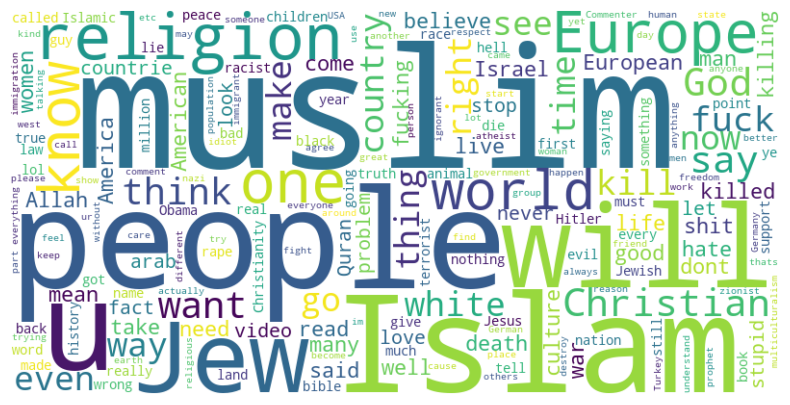

In [31]:
# unprocessed text word cloud --> non-toxic

word_cloud_label(df,label=0, processed = False,bigram = False)

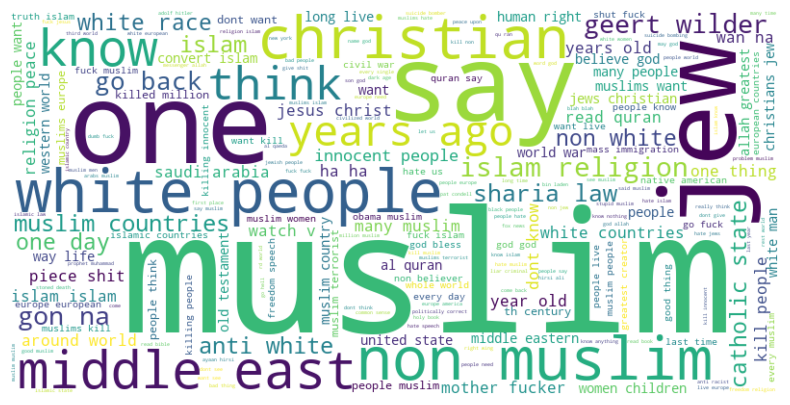

In [32]:
#processed text word cloud--> non-toxic

word_cloud_label(df,label=0, processed = True,bigram = True)

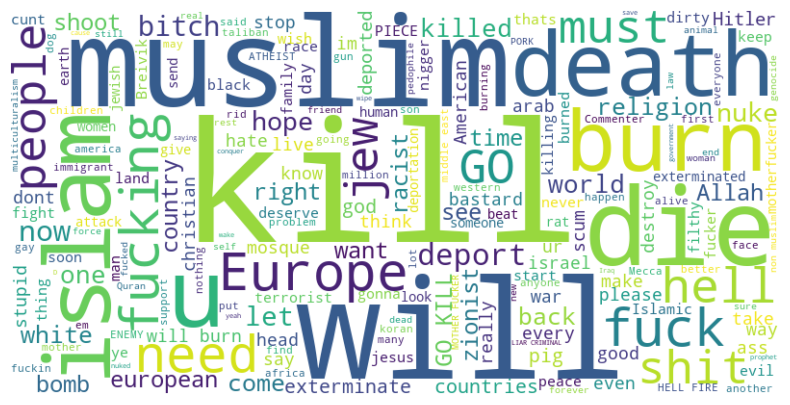

In [33]:
#unprocessed text word cloud ==> toxic

word_cloud_label(df,label=1, processed = False,bigram = False)

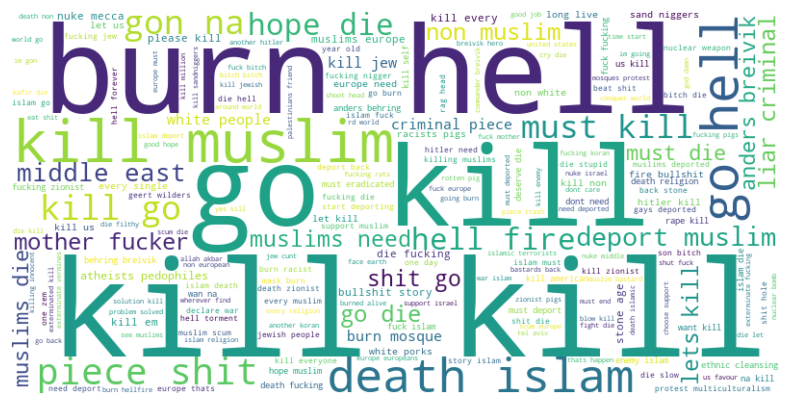

In [34]:
#processed text word cloud--> toxic

word_cloud_label(df,label=1, processed = True,bigram = True)

Some of the insights that we get from these word clouds are:
- Most violent comments refer to religion, ethnicity, countries, insults, and people adjetives.
- For both cases (violent and non-violent) we can see a slightly difference on the size of the words when comparing before and after text processing.
- Some "1-letter words" and words that appear multiple times are not present in the processed clouds, which indiciates a succesful removal of these type of words.

Lets look at the frequency of these words

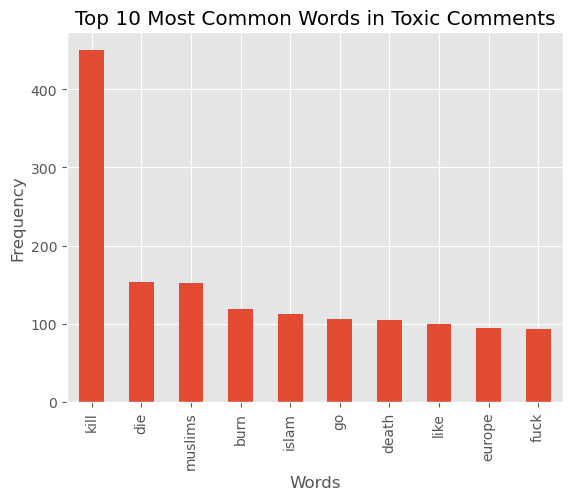

In [35]:
words_in_toxic = pd.Series(' '.join(df[df.label == 1]['cleaned_text']).split())
word_counts = words_in_toxic.value_counts()
# Plot the top 10 most common words
top_words_toxic = word_counts.head(10)
top_words_toxic.plot(kind='bar')
plt.title('Top 10 Most Common Words in Toxic Comments')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


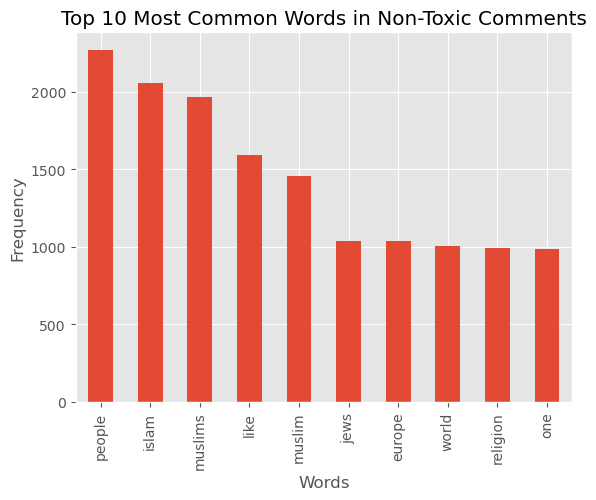

In [36]:
words_in_non_toxic = pd.Series(' '.join(df[df.label == 0]['cleaned_text']).split())
word_counts1 = words_in_non_toxic.value_counts()
# Plot the top 10 most common words
top_words_non_toxic = word_counts1.head(10)
top_words_non_toxic.plot(kind='bar')
plt.title('Top 10 Most Common Words in Non-Toxic Comments')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


We will perform __sentence tokenization__ on the comments and explore the differences in its lengths.

If it's a significant feature we could even __use the sentence length as a feature__.

Let's apply sentence tokenization in our text and __create a new column__ with the sentence length.

In [37]:
# sentence tokinization and new column of its length
df['sent_count'] = df.text.apply(lambda x: len(sent_tokenize(x)))

In [38]:
# visualizing some rows with more than 4 sentences
df[df.sent_count>4].tail()[['text', 'sent_count', 'label']]

,text,sent_count,label
10393,I agre my bro!!!!FUCK THE ISLAM!!!!!Greetings ...,9,1
10398,"and i well fuck you with big,biger and bigest ...",7,0
10401,SERBIA suportetd you my BRO!!!!!!!!KILL MUSLIM...,5,1
10467,FUCK YOU MOTHERFUCKER!!!!!!!WEE WEELL KILL YOU...,6,1
18862,"u see, i dont understand why ppl like to make ...",5,0


In [39]:
# check the statistical description of sent_count grouped by violent and non-violent comments
df.groupby(by = 'label')['sent_count'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,26817.0,1.052541,0.257999,1.0,1.0,1.0,1.0,11.0
1,1359.0,1.124356,0.450808,1.0,1.0,1.0,1.0,9.0


We found that the __sentence length is mostly 1 for most values__ (violent or non-violent indistinguishably).

This will __not contribute much value to a future model training__.

After exploring the sentence length in both the classes, it is found that this feature is not relevant and might not be valuable for the model.

Let's __proceed with the word tokenization__ and follow similar steps to find out if the word length it's a significant feature.

In [40]:
def token_(text):
    """
    arg: passing the cleaned_v_1 column
    
    function: creating a word_token column with empty list for nan values
    
    return: new column named word_tokens
    """
    #checking for text cell only
    if isinstance(text,str): 
        word_tok=word_tokenize(text.lower())
        return(word_tok)
    #for empty cell
    else:
        return([])

# using the implemented method, let's apply word tokenization on our original clean data column 'cleaned_v_1'
df['word_count']=df['cleaned_text'].apply(lambda x: len(token_(x)))

In [41]:
df[df.word_count>4].tail()[['text', 'word_count', 'label']] # visualizing some rows with more than 4 words

,text,word_count,label
28285,the are no risk from islam risk is from NEW WO...,12,0
28286,yeah we are all monsters..I'm gonna kill u rig...,6,1
28288,have you EVER been to Serbia or kosovo...fucki...,7,0
28289,"probably u mean to this monsters, fucker /watc...",9,0
28290,the fucking funniest thing is that fucking ame...,9,0


In [42]:
# check the statistical description of word_count grouped by violent and non-violent comments
df.groupby(by = 'label')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,26817.0,7.233956,6.070453,1.0,3.0,6.0,9.0,91.0
1,1359.0,7.906549,6.857112,1.0,4.0,6.0,10.0,58.0


In [43]:
# check the correlation between our columns and the target column
df.corr(numeric_only = True)['label'] * 100

index                   3.363932
label                 100.000000
word_count              2.357718
char_count              1.190459
special_char_count      1.050799
numerics_count         -2.007055
upper_count             7.838785
lower_count            -1.480779
stopwords_count        -0.259985
unique_words_count      1.689508
sent_count              5.680069
Name: label, dtype: float64

After checking the correlation between the word count and our label, it is found that this feature is also not important and might not be valuable for the model.

Let's start with the word vectorization methods.

### 5. Word Vectorization methods

Before applying word vectorization methods, we will __apply lemmatization__ on our words.

This will convert our words into its __root form__, __considerably reducing the number of unique words__ and also provide the word tokens.

One consequence of lemmatizing our words will be __reducing the number of columns__ that we'll get after applying a word vectorization technique in later steps.

Lets create a custom __LemmaTokenizer__ with tokenizer and necessary features to fit it into the pipeline

In [44]:
from nltk import pos_tag, word_tokenize # pos tagging and word tokenization
from nltk.corpus import  wordnet # wordnet database use for lemmatization
from nltk.stem import WordNetLemmatizer # lemmatization operator
from sklearn.model_selection import train_test_split # split operation for model training

class LemmaTokenizer:
    # implementing a custom lemma tokenizer for our own purposes
    
    def __init__(self):
        self.download_assets()
        self.wnl = WordNetLemmatizer()

    @classmethod
    def download_assets(cls)->None:
        """
        Download the necessary assets for the tokenizer

        :return: None
        """
        nltk.download("wordnet", quiet=True)
        nltk.download("punkt", quiet=True)
        nltk.download("omw-1.4", quiet=True)
        nltk.download("averaged_perceptron_tagger", quiet=True)

    def __call__(self, doc):
        """
        Tokenize and lemmatize the document

        :param doc: The document to tokenize and lemmatize

        :return: The tokenized and lemmatized document
        """
        nltk_tagged = pos_tag(word_tokenize(doc))
        
        wordnet_tagged = ((x[0], self.nltk_pos_tagger(x[1])) for x in nltk_tagged)

        return [ self.wnl.lemmatize(token, tag) for token, tag in wordnet_tagged ]

    def nltk_pos_tagger(self, nltk_tag):
        """
        Convert the nltk tag to wordnet tag

        :param nltk_tag: The nltk tag

        :return: The wordnet tag
        """
        if nltk_tag.startswith("J"):
            return wordnet.ADJ
        elif nltk_tag.startswith("V"):
            return wordnet.VERB
        elif nltk_tag.startswith("N"):
            return wordnet.NOUN
        elif nltk_tag.startswith("R"):
            return wordnet.ADV
        else:
            return wordnet.NOUN

In [45]:
def split_data(df, test_size):
    """
    Split the data into training and testing subsets

    :param df: The dataframe to split
    :param test_size: The size of the testing data

    :return: The training and testing data
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("df must be a pandas DataFrame")

    if not isinstance(test_size, float):
        raise ValueError("test_size must be a float")
    
    if test_size <= 0 or test_size >= 1:
        raise ValueError("test_size must be a float between 0 and 1")
    
    # Check in the columns are present
    if "text" not in df.columns or "label" not in df.columns:
        raise ValueError("df must have a 'text' and 'label' column")
    else:
        x_raw, y = df["text"], df["label"]
        x_train, x_test, y_train, y_test = train_test_split(
            x_raw.values, y.values, test_size=test_size, stratify=y, random_state=0
        )
        x_train, x_test = x_train.flatten(), x_test.flatten()
        return x_train, x_test, y_train, y_test


For starters, let's create a new DataFrame using only 2 columns:
- __clean text__ (after processing)
- __label__ (target column)

Our word vectorization methods will be applied over the clean comment texts.

In [46]:
new_df = pd.DataFrame(columns = ['text','label'])
new_df['text']= df.cleaned_text
new_df['label']= df.label
new_df.head()

,text,label
0,europeans want change way life customs makes e...,0
1,muslims want assimilate properly european soci...,0
2,ok europe soon rebel like spain drive killed,1
3,forsee big civil war europe future muslims lea...,0
4,islam simple humanitarian attractive religion,0


Now that we have a new DataFrame, let's go ahead and utilize our previously implemented method

to __split our dataset into test and train subsets__.

In [47]:
# define 10% for our test subset and 90% for the train subset
test_size = 0.1
x_train, x_test, y_train, y_test = split_data(new_df, test_size)

In [48]:
# let's display some subset values to make sure that they were split properly
display(x_train[-5:])
eda.print_line(50)
display(x_train[-5:])
eda.print_line(50)
display(y_train[-15:])
eda.print_line(50)
display(y_test[-15:])

array(['hey dumb camel fucking troll get back bridge mentally challenged trolls',
       'one race', 'bitch look human', 'reflected attitudes people laws',
       'well whole immaculate conception story nice think b although would rather around people seriously believe jesus seems whole message love fellow man kill anyone different religion'],
      dtype=object)

--------------------------------------------------


array(['hey dumb camel fucking troll get back bridge mentally challenged trolls',
       'one race', 'bitch look human', 'reflected attitudes people laws',
       'well whole immaculate conception story nice think b although would rather around people seriously believe jesus seems whole message love fellow man kill anyone different religion'],
      dtype=object)

--------------------------------------------------


array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

--------------------------------------------------


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

As we can see, the dataset was __properly split into test and train subsets__, for both X (text) and Y (label) columns.

We can proceed to word vectorization methods, starting with __Bag Of Words__.

## Bag of Words

Let's use this word vectorization technique first because it is __easy to understand__ at first glance and for its __simplicity__.

This technique will allow us to __extract relevant features from our texts__ and use them for modeling.

But, the main purpose behind Bag of Words is to __convert text into numbers__ (vectorization), so that it can be used for model training.

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

# Let's instantiate a CountVectorizer used to apply a Bag of Words technique
vectorizer = CountVectorizer(
    tokenizer=LemmaTokenizer(), # Use our custom lemma tokenizer
    strip_accents="unicode", # Remove accents and perform other character normalization
    ngram_range=(1, 2), # Use unigrams and bigrams
    min_df=0.0005, # Ignore terms that have a document frequency strictly lower than the given threshold
    max_df=0.8, # Ignore terms that have a document frequency strictly higher than the given threshold
)
vectorizer

CountVectorizer(max_df=0.8, min_df=0.0005, ngram_range=(1, 2),
                strip_accents='unicode',
                tokenizer=<__main__.LemmaTokenizer object at 0x0000026E6C003C50>)

We have decided to __include bigrams to capture the context information of the comments__.

This will __drastically increase our number of columns__, however, some of the __bigram columns may have stronger correlation__ with the target, than unigrams columns.

To discover this, let's fit transform our train data using our CountVectorizer.

In [50]:
arr = vectorizer.fit_transform(x_train)
arr.toarray()

D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [51]:
# let's print the number of rows & columns
print(arr.shape[0]) # number of rows
print(arr.shape[1]) # number of columns

25358
2299


In [52]:
# let's save and print the column names
colnames = vectorizer.get_feature_names_out()
print(colnames)

['ability' 'able' 'abortion' ... 'zionist' 'zionist jew' 'zionists']


A better way to __visualize our Bag of Words__ is through a Pandas DataFrame.

Let's turn our array of 1 and 0's into a dataframe, with their corresponding columns __(unigrams and bigrams)__.

In [54]:
pd.DataFrame(data=arr.toarray(), columns = colnames)

,ability,able,abortion,abraham,absolute,absolutely,abuse,accept,accord,account,...,yet,york,young,youre,youtube,yr,zionism,zionist,zionist jew,zionists
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25355,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's remember that Bag Of Words counts the __frequency of words__ on each document (each row).

So, every __unique word will be converted into a column__, and the text column will be converted into 1 and 0's for each column.

The __problem with this approach__ is that most __frequent words__ will have higher values, which mean they will have __more weight__ and importance within a machine learning model training.

But, for now let's go ahead and __train a model__ using this current results.

On later steps, we will use TF-IDF word vectorization technique for better results.

### 6. Model Building

Let's remember that we really have __imbalanced data__ as visualized during our EDA section.

Approximately __95%__ of our data are __non-violent__ comments and __5%__ are __violent__ comments.

To deal with this we have decide to apply __SMOTE: Synthetic Minority Oversampling Technique__.

Otherwise if we train our model with the data as-is, it will __ignore minority classes and end up with poor performance__.

What __SMOTE does__ in general words is:

- __replicate data__ belonging to the minority class
- __create new examples__ based on the existing ones (from the minority class)
- it is basically a __data augmentation__ technique

We will also use a __Naive Bayes model__ for this __supervised classification problem__.

Why? Because Naive Bayes model is known for its speed and high accuracy on __large datasets__ (just like ours).

In [57]:
#!pip install imblearn

In [60]:
from imblearn.over_sampling import SMOTE # for SMOTE technique
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Naive Bayes ML model
model = MultinomialNB()

# Apply SMOTE for oversampling
pipeline = make_pipeline(vectorizer,SMOTE(), model)

print("Model training") # training our model
pipeline.fit(x_train, y_train)

print("Model evaluation") # evaluate our model (model accuracy)
pipeline.score(x_test, y_test)
y_pred_test = pipeline.predict(x_test)

# Let's calculate some key performance measures like recall and f1-score
f1 = f1_score(y_test, y_pred_test, average="macro")
print(balanced_accuracy_score(y_test, y_pred_test))
accuracy_score(y_test, y_pred_test)
print(classification_report(y_test, y_pred_test))

num_features_basic = vectorizer.transform(x_test).shape[1]

Model training


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model evaluation
0.781791463789095
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2682
           1       0.37      0.62      0.46       136

    accuracy                           0.93      2818
   macro avg       0.67      0.78      0.71      2818
weighted avg       0.95      0.93      0.94      2818



As we can see, the model has been __trained succesfully__, and we even have some key __metrics like recall and f1-score__.

The results look accurate for non-violent comments, however they don't look very promising for violent comments detection.

One way to visualize the __performance of our classification model__ is through the use of a confusion matrix.

Let's __implement a function__ that __plots a confusion matrix__, and __evaluate__ our model __results__.

Number of features: 2299
Accuracy: 0.9300922640170334
F1 Score: 0.7114498301640145


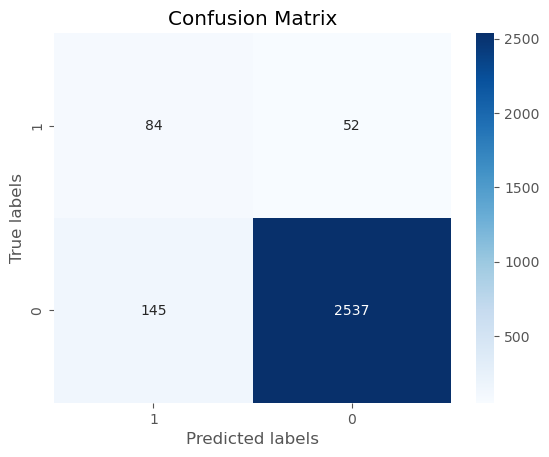

In [61]:
print(f"Number of features: {num_features_basic}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"F1 Score: {f1}")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot the confusion matrix

    :param y_true: The true labels
    :param y_pred: The predicted labels
    :param labels: The labels to use
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

plot_confusion_matrix(y_test, y_pred_test, [1, 0])

From our confusion matrix we can get the following insights:

- Most of __non-violent comments were predicted succesfully__.
- We have way __too many false positives__ (non-violent comments predicted as violent). This could be once again, __due to the highly imbalanced data__.
- Over __60% of violent comments were predicted accurately__, which is a great start.

What we can do is experiment with other models like:
- __Support Vector Classifier (SVC)__
- __Logistic Regressor__
- __Random Forest__
- __Gradient Boosting Classifier__

And compare results. Let's go ahead train the data for each model, and plot a confusion matrix for each model.

Model training for MultinomialNB()


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model evaluation
0.781791463789095
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2682
           1       0.37      0.62      0.46       136

    accuracy                           0.93      2818
   macro avg       0.67      0.78      0.71      2818
weighted avg       0.95      0.93      0.94      2818



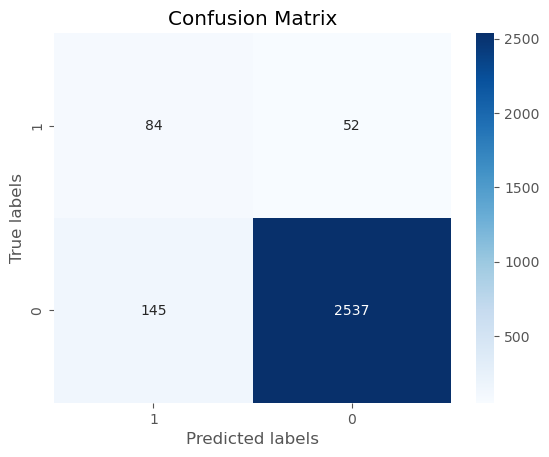

Model training for SVC()


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model evaluation
0.6781347326402597
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      2682
           1       0.22      0.43      0.29       136

    accuracy                           0.90      2818
   macro avg       0.60      0.68      0.62      2818
weighted avg       0.93      0.90      0.91      2818



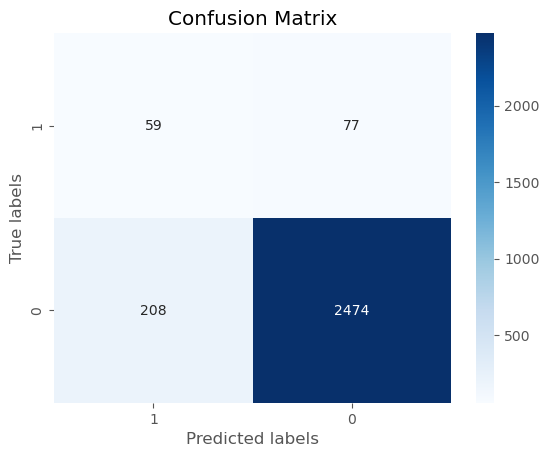

Model training for LogisticRegression()


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model evaluation
0.7698079791200596
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      2682
           1       0.27      0.62      0.38       136

    accuracy                           0.90      2818
   macro avg       0.63      0.77      0.66      2818
weighted avg       0.95      0.90      0.92      2818



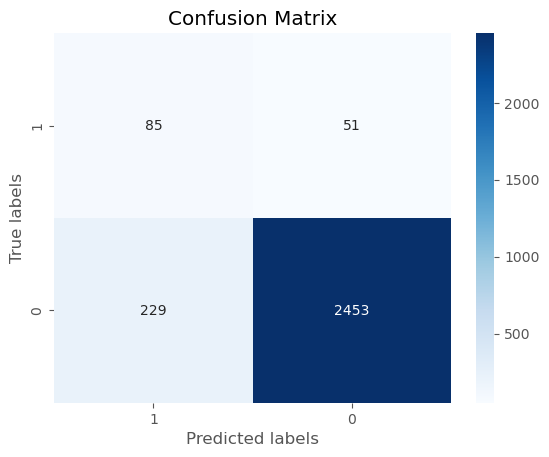

Model training for RandomForestClassifier()


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model evaluation
0.7189268324779576
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2682
           1       0.21      0.54      0.30       136

    accuracy                           0.88      2818
   macro avg       0.59      0.72      0.62      2818
weighted avg       0.94      0.88      0.90      2818



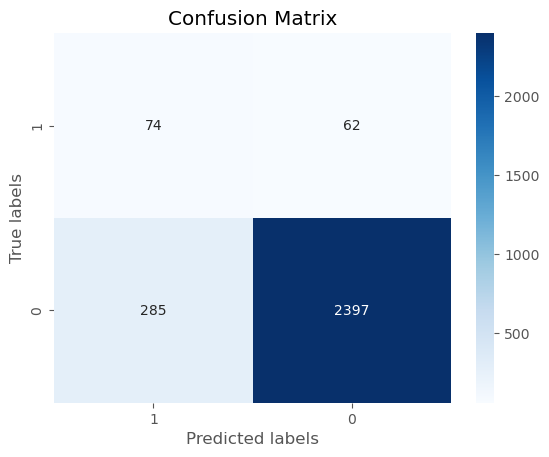

Model training for GradientBoostingClassifier()


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model evaluation
0.8249769706540335
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2682
           1       0.39      0.71      0.50       136

    accuracy                           0.93      2818
   macro avg       0.69      0.82      0.73      2818
weighted avg       0.96      0.93      0.94      2818



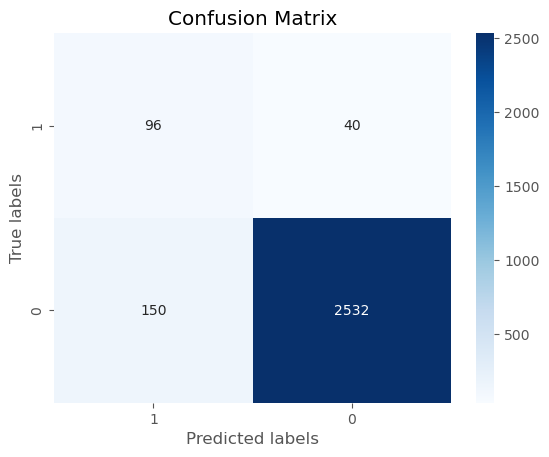

In [64]:
# Multiple Models Training
models = (MultinomialNB(),SVC(),LogisticRegression(),RandomForestClassifier(), GradientBoostingClassifier())

for model in models:
        # Apply SMOTE for oversampling
    pipeline = make_pipeline(vectorizer,SMOTE(), model)
    
    print(f"Model training for {str(model)}")
    pipeline.fit(x_train, y_train)
    
    print("Model evaluation")
    pipeline.score(x_test, y_test)
    y_pred_test = pipeline.predict(x_test)
    
    f1 = f1_score(y_test, y_pred_test, average="macro")
    print(balanced_accuracy_score(y_test, y_pred_test))
    accuracy_score(y_test, y_pred_test)
    print(classification_report(y_test, y_pred_test))
    plot_confusion_matrix(y_test, y_pred_test, [1, 0])

Some insights from the results:
- __Most models__ have __worst results than our previous Naive Bayes__, and it's proven by the number of true positives and overall model accuracy.
- However, there is one model that presented __better results: GradientBoostingClassifier__. This model __predicted over 70% of violent comments accurately__, which is an impressive result given the fact that we are working with Bag of Words technique.
- An acceptable option will be to __continue working with the GradientBoostingClassifier model.__

## TF-IDF (Term Frequency - Inverse Document Frequency)

Let's use __TF-IDF word vectorization technique__ now.

With this technique we don't have to deal with the main problem of Bag of Words bacause

TF-IDF __gives less weight to most frequent words__ (less importance for ML models).

Usually, __most frequent words__ (like stopwords) __are less relevant__ and less significant within the text meaning and classification problems.

Let's go ahead and __instantiate a TfidVectorizer__ using our __custom LemmaTokenizer and some parameters__.

Once again, we will consider __unigrams and bigrams.__

However, this time, we will only consider a __maximum of 3000 columns/features__ given the large size of our data and lack of resources.

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=LemmaTokenizer(),
    strip_accents="unicode", # Remove accents and perform other character normalization
    ngram_range=(1, 2), # Use unigrams and bigrams
    max_features = 3000
)
tfidf_vectorizer

TfidfVectorizer(max_features=3000, ngram_range=(1, 2), strip_accents='unicode',
                tokenizer=<__main__.LemmaTokenizer object at 0x0000026E3914ED90>)

In [68]:
b = tfidf_vectorizer.fit_transform(x_train)
b.toarray()

D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
# let's print the number of rows & columns
print(b.shape[0]) # number of rows
print(b.shape[1]) # number of columns

25358
3000


In [70]:
colnames = tfidf_vectorizer.get_feature_names_out()
print(colnames)

['aan' 'ability' 'able' ... 'zionist jew' 'zionists' 'zu']


In [72]:
pd.DataFrame(data=b.toarray(), columns=colnames)

,aan,ability,able,abortion,abraham,absolute,absolutely,abt,abuse,accept,...,yr old,yt,zealot,zero,zijn,zionism,zionist,zionist jew,zionists,zu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that we have our __TF-IDF dataset__ let's follow the same previous steps that we did with Bag of Words

so that we can compare results and get into a conclusion.

Once again, we will perform:

- __experiment with different models__
- __apply SMOTE technique to deal with our imbalanced data__
- __plot confusion matrixes__
- __compare results__

In [73]:
tfidf_pipeline = make_pipeline(tfidf_vectorizer,SMOTE(), MultinomialNB())

print("Model training")
tfidf_pipeline.fit(x_train, y_train)

print("Model evaluation")
tfidf_pipeline.score(x_test, y_test)
y_pred_test = pipeline.predict(x_test)

f1 = f1_score(y_test, y_pred_test, average="macro")
print(balanced_accuracy_score(y_test, y_pred_test))
accuracy_score(y_test, y_pred_test)


Model training


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model evaluation
0.8249769706540335


0.9325762952448545

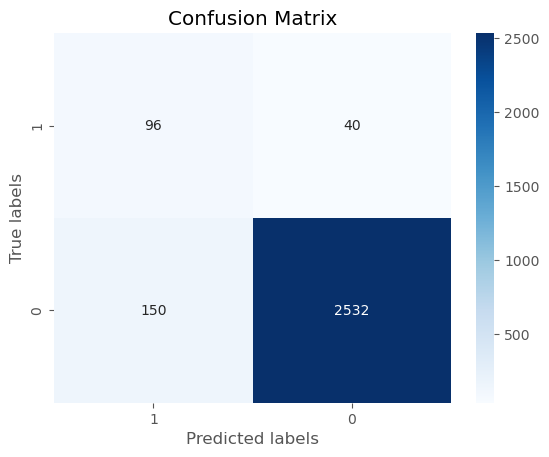

In [74]:
plot_confusion_matrix(y_test, y_pred_test, [1, 0])

Starting from the Naive Bayes model, we already see better results than Bag of Words.

The main reason is __because highly frequent words__ have been balanced to contribute less importance during our model training, as they probably __contain less relevant information__.

For this Naive Bayes model, __over 70% violent comments were predicted correctly.__

- (TP + FP) / POSITIVES = (96 + 40) / 136 = __70.58%__

Let's go ahead and test the other previous mentioned models.

Model training for MultinomialNB()


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model evaluation
0.8182737860244769
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      2682
           1       0.24      0.76      0.37       136

    accuracy                           0.87      2818
   macro avg       0.61      0.82      0.65      2818
weighted avg       0.95      0.87      0.90      2818



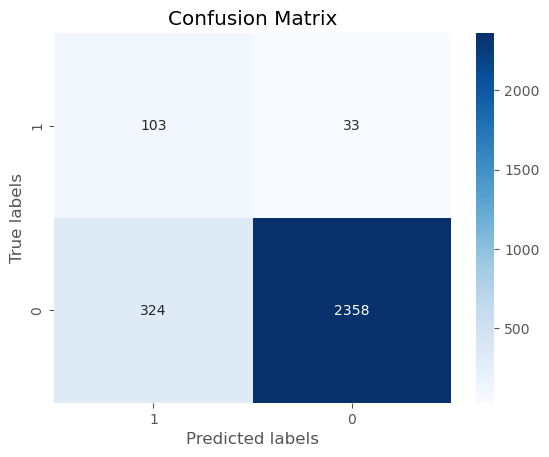

Model training for SVC()


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model evaluation
0.7176876343378514
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2682
           1       0.53      0.46      0.49       136

    accuracy                           0.95      2818
   macro avg       0.75      0.72      0.73      2818
weighted avg       0.95      0.95      0.95      2818



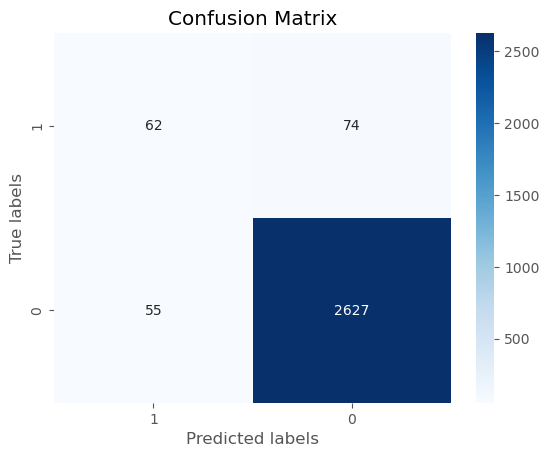

Model training for LogisticRegression()


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model evaluation
0.8252758038338378
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2682
           1       0.29      0.74      0.42       136

    accuracy                           0.90      2818
   macro avg       0.64      0.83      0.68      2818
weighted avg       0.95      0.90      0.92      2818



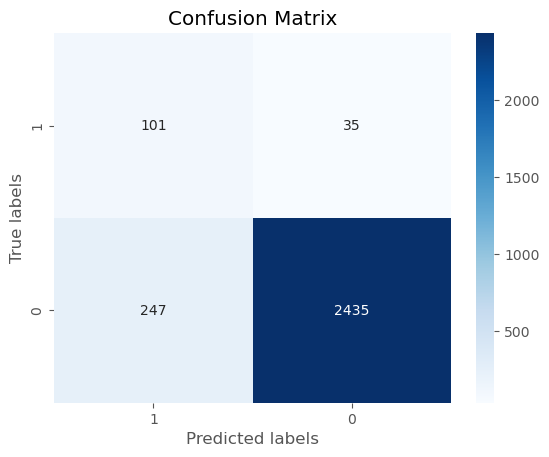

Model training for RandomForestClassifier()


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model evaluation
0.7744604553230687
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2682
           1       0.54      0.57      0.56       136

    accuracy                           0.96      2818
   macro avg       0.76      0.77      0.77      2818
weighted avg       0.96      0.96      0.96      2818



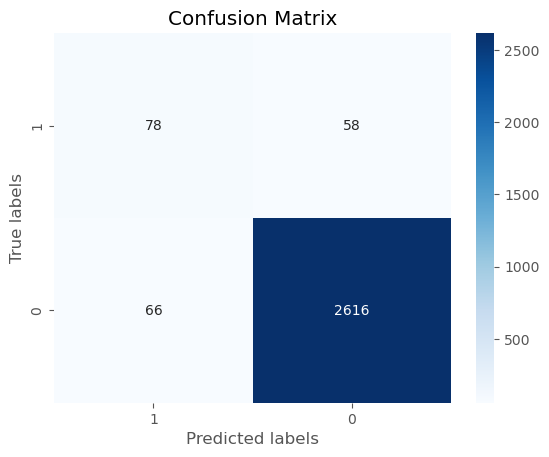

Model training for GradientBoostingClassifier()


D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model evaluation
0.8552989428433566
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      2682
           1       0.33      0.79      0.46       136

    accuracy                           0.91      2818
   macro avg       0.66      0.86      0.71      2818
weighted avg       0.96      0.91      0.93      2818



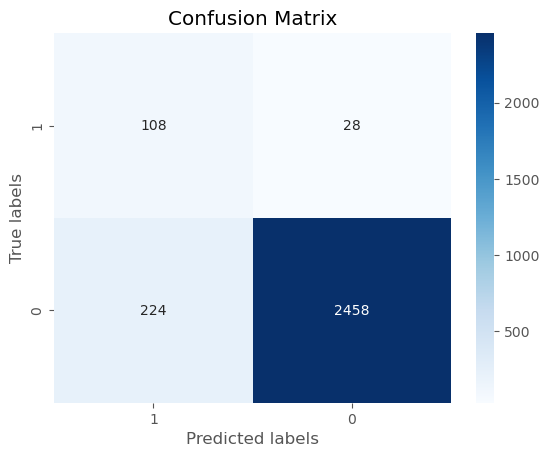

In [75]:
models = (MultinomialNB(),SVC(),LogisticRegression(),RandomForestClassifier(), GradientBoostingClassifier())

for model in models:
        # Apply SMOTE for oversampling
    pipeline = make_pipeline(tfidf_vectorizer,SMOTE(), model)
    
    print(f"Model training for {str(model)}")
    pipeline.fit(x_train, y_train)
    
    print("Model evaluation")
    pipeline.score(x_test, y_test)
    y_pred_test = pipeline.predict(x_test)
    
    f1 = f1_score(y_test, y_pred_test, average="macro")
    print(balanced_accuracy_score(y_test, y_pred_test))
    accuracy_score(y_test, y_pred_test)
    print(classification_report(y_test, y_pred_test))
    plot_confusion_matrix(y_test, y_pred_test, [1, 0])

This time (using TF-IDF) we see totally different results. Our main insights are:
- __Only 2 out of 5 models performed poorly__: RandomForest and SVC
- The other __3 models (LogisticRegression, GradientBoostingClassifier, MultinomialNB) present a relative high accuracy of over 80%__
- __In conclusion, for large imbalanced datasets, TF-IDF may be a better approach__ because:
    - Large datasets may contain lots of stopwords and frequent words
    - The influence of this words over the model gets amortized by the TF-IDF technique, and we have proven that using both approaches.

### 7. Evaluating Model Results

To finalize the project, let's __compare our results with more real-world data from Youtube comments__.

We will use our best pipeline (TF-IDF) out of the two approaches.

First let's start by __saving the model as a 'pkl'__ file.

In the real world we may need to save our models as pickle files to re-use them in different applications without having to retrain the models all over again.

In [88]:
## Save the model as a pickle file

import joblib

joblib.dump(tfidf_pipeline, "model.pkl") # using pipeline with best performance

## Load the model from a pickle file

model = joblib.load("model.pkl")

model.score(x_test, y_test)

## Predict

0.8750887154009936

Now that we have loaded our model,

let's __gather data__ from a different __CSV file__ that contains more __Youtube comments with different annotations__.

In [89]:
# !pip install googledrivedownloader

In [102]:
### dowload file from google drive
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1URSwK6HKKbD2LLokDZI4xhzSj07ShkXm', dest_path='./test_youtube.csv')

youtube_data = pd.read_csv('test_youtube.csv')

youtube_data.tail(4)

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
996,Ugifh2DMhBbDkHgCoAEC,XRuCW80L9mA,Stats don`t represent the problem. Race baitin...,True,False,False,False,False,True,True,False,False,False,False,False
997,Ugj_plbGBjjzYXgCoAEC,XRuCW80L9mA,The quote from the mother... Wow that hit hard...,False,False,False,False,False,False,False,False,False,False,False,False
998,Ugj0bah1De8xy3gCoAEC,XRuCW80L9mA,this video is so racist,False,False,False,False,False,False,False,False,False,False,False,False
999,UgjBJKQSoQMQ6ngCoAEC,XRuCW80L9mA,"God, the narrator has such an annoying lisp.",False,False,False,False,False,False,False,False,False,False,False,False


Our data has __12 different annotations__, however we will __focus on the "IsToxic" labels and compare them to our model results__.

Let's define a new dataframe taking only the comments and the IsToxic label.

We can also __proceed to predict the comments using our own trained model__ into a new column.

Finally, as our true labels are "True" or "False" we can map them to 1 or 0 respectively.

In [109]:
## Select the text column and IsToxic column True

youtube_data = youtube_data[["Text", "IsToxic"]]
youtube_data.head()

#Create New Column with prediction 

youtube_data["Predicted"] = model.predict(youtube_data["Text"])

# Map the true labels into 0 and 1's
youtube_data['IsToxic'] = youtube_data['IsToxic'].map({False:0, True:1})

In [110]:
youtube_data.head()

,Text,IsToxic,Predicted
0,If only people would just take a step back and...,0,0
1,Law enforcement is not trained to shoot to app...,1,1
2,\nDont you reckon them 'black lives matter' ba...,1,0
3,There are a very large number of people who do...,0,0
4,"The Arab dude is absolutely right, he should h...",0,0


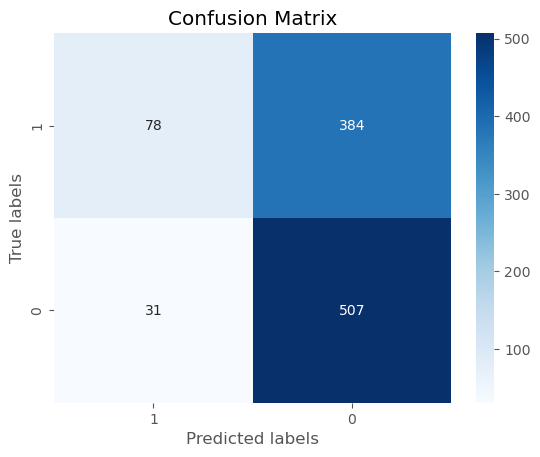

In [111]:
plot_confusion_matrix(youtube_data["IsToxic"], youtube_data["Predicted"] , [1, 0])

__Final insights:__

When using our model with more real-world data we find that only a few toxic comments get predicted as violent.

However, this may be due to the following reasons:
- After some detailed research we find out that our original large dataset is poorly annotated, as some violent comments are labeled as non-violent.
- Our original dataset is originated mostly from religion and ethnicity videos. These topics may not be addressed in most videos, therefore violent comments on these videos get addressed as non-violent (because they don't talk about religion or ethnicity as our main dataset does).

Our proposed ways to tackle these problems on future work:
- Apply other word vectorization methods like Word2Vec
- Revise our dataset and enhance the annotation manually if required.
- Further develop our model training by doing hyper-parameter tuning and testing